In [ ]:
import os

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_FILE_PREFIX = os.path.join('..', 'data', 'memorization_training_results_')

performance = []

for i in range(10):
    single_seed_performance = pd.read_csv(DATA_FILE_PREFIX + str(i) + '.csv')
    single_seed_performance['seed'] = i

    performance.append(single_seed_performance)

performance = pd.concat(performance).reset_index(drop=True)

In [3]:
performance.head()

,model_name,epoch,loss,accuracy,seed
0,One compartment,0,0.705004,0.468750,0
1,One compartment,1,0.702757,0.476562,0
2,One compartment,2,0.701307,0.480469,0
3,One compartment,3,0.698993,0.484375,0
4,One compartment,4,0.699142,0.476562,0


In [4]:
def performance_lineplot(model_name, metric_loss=True, ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()

    if metric_loss:
        metric = 'loss'
    else:
        metric = 'accuracy'

    this_model = performance.query('model_name == @model_name')
    if 'label' not in pltargs:
        pltargs['label'] = model_name
    for seed in this_model.seed.unique():
        this_seed = this_model.query('seed == @seed')
        ax.plot(
            this_seed.epoch,
            this_seed[metric],
            label=pltargs.pop('label', None),
            **pltargs
        )


def performance_bandplot(model_name, metric_loss=True, ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()

    if metric_loss:
        metric = 'loss'
    else:
        metric = 'accuracy'

    alpha = min(pltargs.pop('alpha', 1), 0.8)

    this_model = performance.query('model_name == @model_name').sort_values(
        'epoch'
    )
    if 'label' not in pltargs:
        pltargs['label'] = model_name

    this_std = (
        this_model.groupby(['model_name', 'epoch']).std().sort_values('epoch')
    )
    this_mean = (
        this_model.groupby(['model_name', 'epoch']).mean().sort_values('epoch')
    )

    label = pltargs.pop('label', None)
    maincolor = pltargs.pop('color', None)
    ax.fill_between(
        this_mean.index.get_level_values('epoch'),
        this_mean[metric] - this_std[metric],
        this_mean[metric] + this_std[metric],
        alpha=alpha,
        facecolor=maincolor,
        edgecolor='none',
        **pltargs
    )
    ax.plot(
        this_mean.index.get_level_values('epoch'),
        this_mean[metric],
        label=label,
        color=maincolor,
        **pltargs
    )

In [5]:
palette = {
    'One compartment': 'gray',
    'No BAP': 'xkcd:ocean',
    'BAP': 'xkcd:cherry',
    'Parallel subunits, no BAP': 'xkcd:iris',
    'Parallel subunits + BAP (full PRC model)': 'xkcd:blood orange'
}

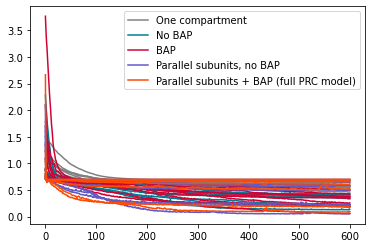

In [6]:
for model_name, colour in palette.items():
    performance_lineplot(model_name, color=colour)
plt.legend()

In [7]:
def savefig(fname, **pltargs):
    plt.savefig(fname, dpi=300, bbox_inches='tight', **pltargs)

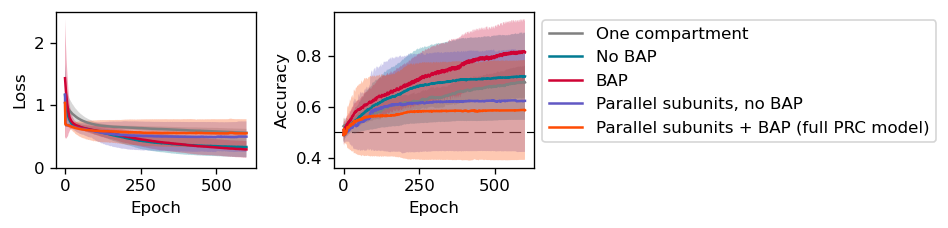

In [8]:
plt.figure(figsize=(8, 2), dpi=120)

plt.subplot(121)
for model_name, colour in palette.items():
    this_mean = performance_bandplot(model_name, color=colour, alpha=0.3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, plt.ylim()[1])

plt.subplot(122)
plt.axhline(0.5, color='k', ls='--', dashes=(10, 5), lw=0.7, zorder=-1)
for model_name, colour in palette.items():
    this_mean = performance_bandplot(
        model_name, metric_loss=False, color=colour, alpha=0.3
    )
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()

savefig(os.path.join('..', 'data', 'loss_trajectory.png'))
plt.show()

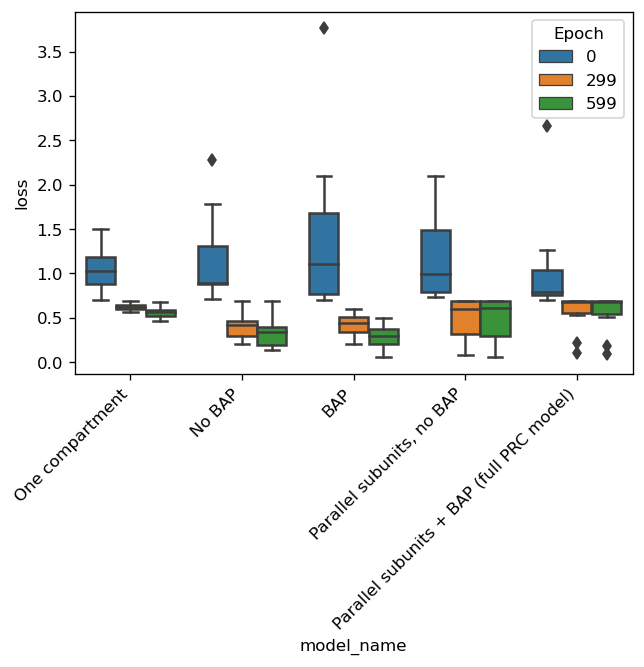

In [9]:
plt.figure(dpi=120)

sns.boxplot(
    x='model_name',
    y='loss',
    hue='epoch',
    data=performance.query('epoch in [0, 299, 599]'),
)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Epoch')

savefig(os.path.join('..', 'data', 'loss_boxplot.png'))

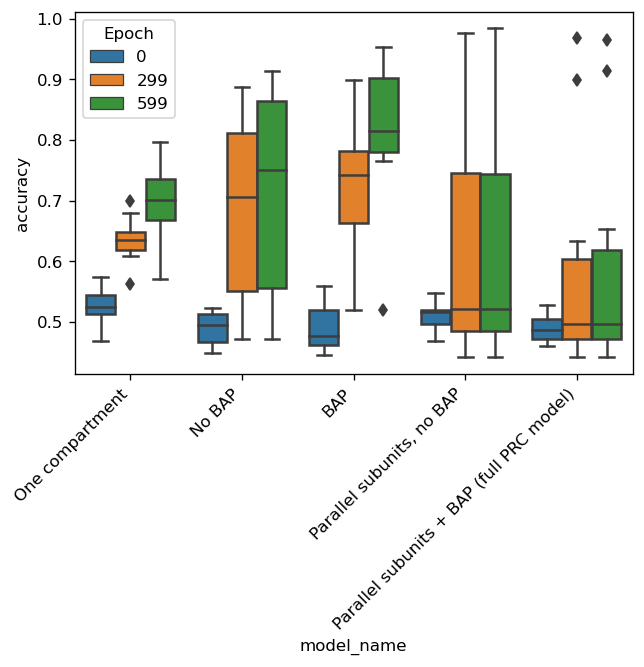

In [10]:
plt.figure(dpi=120)

sns.boxplot(
    x='model_name',
    y='accuracy',
    hue='epoch',
    data=performance.query('epoch in [0, 299, 599]'),
)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Epoch')

savefig(os.path.join('..', 'data', 'accuracy_boxplot.png'))